## Project 5 - Outage Prediction using weather radar data


---

***Notebook Overview***


In this notebook, I will construct:

### Dowload radar weather from S3 bucket

- Dataset is collected from 3 radar station 
    - `KENX,EAST BERNE, NY`
    
    - `KBGM, BINGHAMTON, NY`

    - `KOKX,UPTON, NY`


- Collect information of power grid from OpenStreetMap Data
    - Step 1 : Go to https://export.hotosm.org/en/v3/
    - Step 2 : Start exporting
    - Step 3 : Select area you want to ectract data, ddd name, select format file( *shp), choose 'power' in data tab
    - Step 4 : Create export



- Extract the outage locations from Central Hudson dataset

- Plot the outages and transmission power grid topology in this area


### Extract radar dataset 

- Extract the number of outages in 2-hour window of radar weather

- Create animated image 



### To install the dependencies:

`
conda install -c conda-forge arm_pyart
`








In [1]:
print(__doc__)

import os
from os import chdir
import pandas as pd
import numpy as np
import json
import urllib.request
import matplotlib.pyplot as plt

from time import sleep
from datetime import datetime, timedelta
import tempfile

from boto.exception import BotoServerError
from boto.s3.connection import S3Connection
import cartopy
from netCDF4 import num2date
import pyart
import pytz
import pyproj

%matplotlib inline

Automatically created module for IPython interactive environment

## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



# Helper functions

In [2]:
os.getcwd()

'/Users/ducvu/Desktop/metis-bootcamp-summer2019/chi19_ds11_duc/student_submissions/projects/project-05'

# CFRadial - Weather Radar Data Representation

In [3]:
work_dir = '/Users/ducvu/Documents/Argonne_Analyitcs/data'
filename = 'KENXd20161227t0000.cfradial'
full_file_name = os.path.join(work_dir, filename)
full_file_name

'/Users/ducvu/Documents/Argonne_Analyitcs/data/KENXd20161227t0000.cfradial'

In [32]:
#Read the data into the Py-ART Common Data Model
radar = pyart.io.read(full_file_name)

#print(radar.info())
#print(radar.fields)
#field data
print(radar.fields.keys())


# longitude and latitude in degrees, altitude in meters
gate_x = radar.gate_x['data']
gate_y = radar.gate_y['data']
gate_z = radar.gate_z['data']
gate_x

dict_keys(['reflectivity', 'velocity', 'differential_reflectivity', 'spectrum_width', 'differential_phase', 'cross_correlation_ratio'])


masked_array(
  data=[[-1993.5695539201065, -2228.1062996372775, -2462.643045354449,
         ..., -430265.455889574, -430499.0436483718, -430732.5434489323],
        [-1986.6856129956016, -2220.4122579762134, -2454.139131223335,
         ..., -428782.94171630306, -429015.69320675265,
         -429248.4446972023],
        [-1980.445144112174, -2213.4377936675673, -2446.4304432229605,
         ..., -427440.5272830312, -427672.4889080905, -427904.5670382352],
        ...,
        [1776.1304210664018, 1985.0676729572383, 2194.000485192031, ...,
         376848.2478085504, 377049.33434086037, 377250.47631472873],
        [1791.9022501373831, 2002.6948402310327, 2213.4829512450156, ...,
         380194.6158903305, 380397.4880473775, 380600.4161382974],
        [1807.2171421403277, 2019.8113180917203, 2232.400976681993, ...,
         383444.03392193076, 383648.63997108897, 383853.30243217136]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False,

## Our radar has  11  sweeps, let's plot the $1^{st}$ and $7^{th}$ sweep 

In [15]:
radar_sweep = radar.extract_sweeps([0])

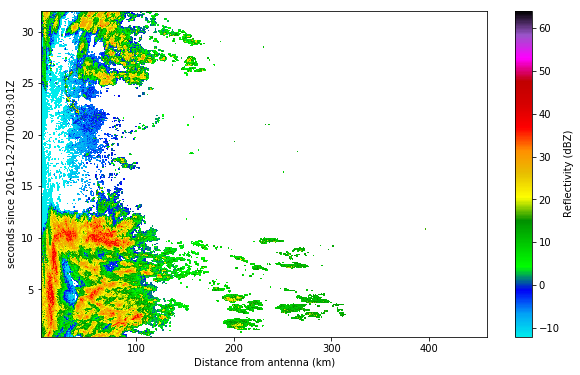

In [16]:
range_array = radar_sweep.range['data']/1000.0
time_array = radar_sweep.time['data']
fig = plt.figure(figsize = [10,6])
plt.pcolormesh(range_array, time_array,
               radar_sweep.fields['reflectivity']['data'],
               cmap = pyart.graph.cm.NWSRef,
               vmin = -12, vmax = 64)
plt.ylabel(radar_sweep.time['units'])
plt.xlabel('Distance from antenna (km)')
plt.colorbar(label = 'Reflectivity (dBZ)')

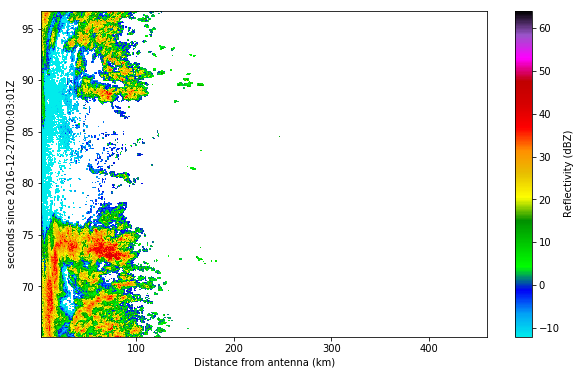

In [17]:
radar_sweep = radar.extract_sweeps([2])
range_array = radar_sweep.range['data']/1000.0
time_array = radar_sweep.time['data']
fig = plt.figure(figsize = [10,6])
plt.pcolormesh(range_array, time_array,
               radar_sweep.fields['reflectivity']['data'],
               cmap = pyart.graph.cm.NWSRef,
               vmin = -12, vmax = 64)
plt.ylabel(radar_sweep.time['units'])
plt.xlabel('Distance from antenna (km)')
plt.colorbar(label = 'Reflectivity (dBZ)')

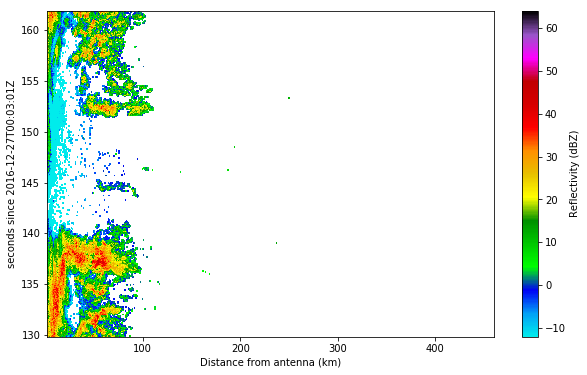

In [18]:
radar_sweep = radar.extract_sweeps([4])
range_array = radar_sweep.range['data']/1000.0
time_array = radar_sweep.time['data']
fig = plt.figure(figsize = [10,6])
plt.pcolormesh(range_array, time_array,
               radar_sweep.fields['reflectivity']['data'],
               cmap = pyart.graph.cm.NWSRef,
               vmin = -12, vmax = 64)
plt.ylabel(radar_sweep.time['units'])
plt.xlabel('Distance from antenna (km)')
plt.colorbar(label = 'Reflectivity (dBZ)')

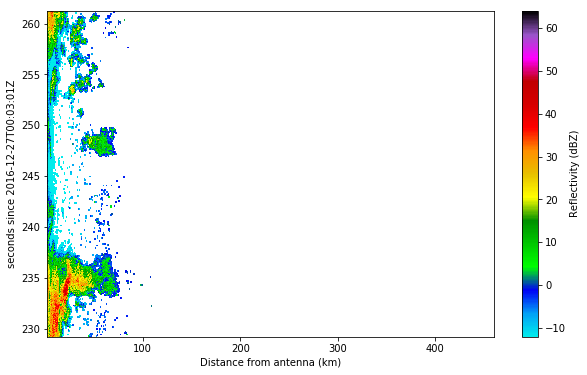

In [19]:
radar_sweep = radar.extract_sweeps([7])
range_array = radar_sweep.range['data']/1000.0
time_array = radar_sweep.time['data']
fig = plt.figure(figsize = [10,6])
plt.pcolormesh(range_array, time_array,
               radar_sweep.fields['reflectivity']['data'],
               cmap = pyart.graph.cm.NWSRef,
               vmin = -12, vmax = 64)
plt.ylabel(radar_sweep.time['units'])
plt.xlabel('Distance from antenna (km)')
plt.colorbar(label = 'Reflectivity (dBZ)')

## Pre-Packaged plotting tools

Py-ART has a number of plotting utilities contained within the graph module. This includes plotting PPIs (constant elevation scans), RHIs (constant azimuth scans) and line plots along rays. In addition it can plot both radial and cartesian data on maps using Matplotlib's Basemap module and (New and experimental) Cartopy.

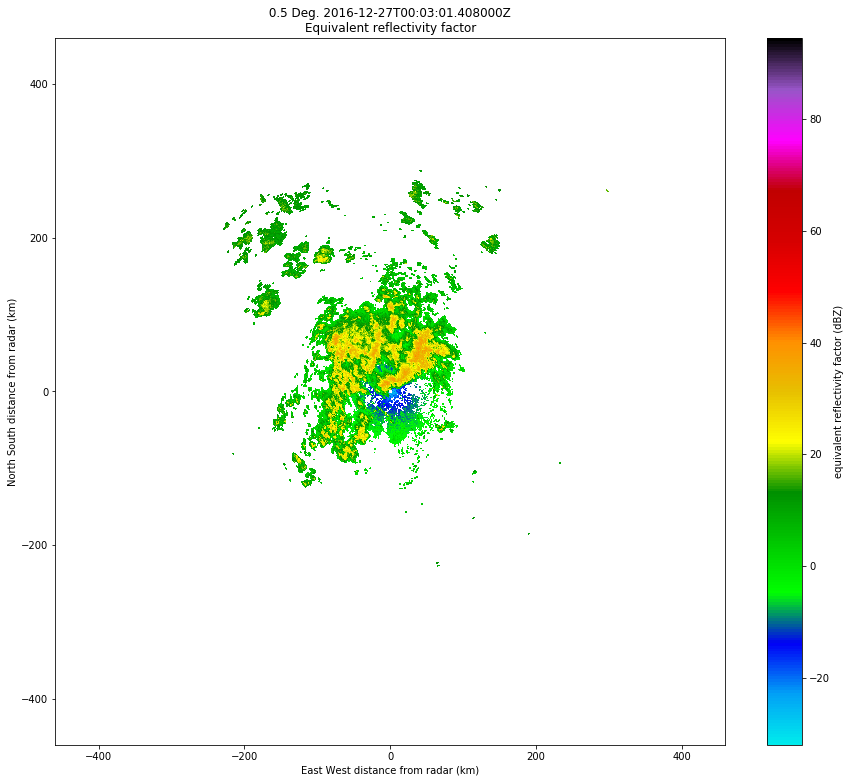

In [27]:
#plotting data from a PPI

#Set up a Matplotlib figure
my_figure = plt.figure(figsize = [15,13])

#Set up a Py-ART display instance
my_display = pyart.graph.RadarDisplay(radar)

#plot a ppi of the data
my_display.plot_ppi('reflectivity', 0)

# 1. ~~~~~~~~~

In [23]:
df_weather_outage = pd.read_pickle('caidi_weather_outage.pkl')
df_weather_outage['Interruption Cause'] = df_weather_outage['Interruption Cause'].str[0]

print(len(df_weather_outage))
#print(list(df_weather_outage))
print(df_weather_outage.columns.values)
df_weather_outage.head()

4323
['Assist Order' 'CAIDI Constant Time (min)' 'CIRCUIT' 'Callout Time (min)'
 'Cause Key' 'Customer Duration' 'Customer Hours' 'Customers Interrupted'
 'Dispatch Time (min)' 'District' 'Duration' 'Electric Interruption Card'
 'En Route Time (min)' 'Eqp Cause Key' 'Equipment Cause'
 'Fuse Card End Time' 'Fuse Card Start Time' 'Fusecard Duration'
 'Hold Time (min)' 'Individual CAIDI Effect' 'LATITUDE' 'LONGITUDE'
 'OMS Case Number' 'Order Number' 'Pole Number' 'Receive Datetime' 'Sort'
 'Source of Information' 'Squirrel' 'Sub Cause' 'Sub Cause Key'
 'Timesheet Employee Count' 'Total Time (min)' 'Travel Time (min)'
 'Work Time (min)' 'Interruption Cause']


,Assist Order,CAIDI Constant Time (min),CIRCUIT,Callout Time (min),Cause Key,Customer Duration,Customer Hours,Customers Interrupted,Dispatch Time (min),District,...,Sort,Source of Information,Squirrel,Sub Cause,Sub Cause Key,Timesheet Employee Count,Total Time (min),Travel Time (min),Work Time (min),Interruption Cause
7,NaN,27.00,3023,NaN,1,36.266678,36.266678,34.0,0.00,Kingston,...,NaN,NM & NV,,"Indeterminable, Ice",87.0,NaN,64,0.00,37.00,Unknown
24,NaN,113.00,2091,NaN,1,6.400000,6.400000,2.0,75.00,Kingston,...,NaN,NM & NV,,"Indeterminable, Ice",87.0,NaN,192,0.00,79.00,Unknown
28,NaN,145.00,341,NaN,1,6.166666,6.166666,2.0,0.00,Kingston,...,NaN,NM & NV,,"Indeterminable, Ice",87.0,NaN,185,39.00,1.00,Unknown
41,NaN,0.00,341,NaN,1,67.166666,67.166666,2.0,0.00,Kingston,...,NaN,NM & NV,,"Indeterminable, Wind/Rain",90.0,NaN,2015,0.00,0.00,Unknown
57,NaN,138.98,6073,NaN,1,509.366706,509.366706,118.0,138.77,Poughkeepsie,...,NaN,O.M.,,"Indeterminable, Wind/Rain",90.0,NaN,259,31.83,88.18,Unknown


In [25]:
df_weather_outage_2011_2012 = df_weather_outage[(df_weather_outage['Fuse Card Start Time'] >= '2011-01-01 00:00:00') & 
                                                (df_weather_outage['Fuse Card Start Time'] <= '2012-12-31 11:59:59' )]

df_weather_outage_2011_2012['Start Date'] = df_weather_outage_2011_2012['Fuse Card Start Time']
df_weather_outage_2011_2012['End Date'] =  df_weather_outage_2011_2012['Start Date'].apply(lambda x : x+timedelta(days=1))

df_weather_outage_2011_2012['Start Date'] = df_weather_outage_2011_2012['Start Date'].apply(lambda x : x.strftime('%Y%m%d'))
df_weather_outage_2011_2012['End Date'] = df_weather_outage_2011_2012['End Date'].apply(lambda x : x.strftime('%Y%m%d'))

print('number of date : ', len(df_weather_outage_2011_2012['Start Date'].unique()), len(df_weather_outage_2011_2012['End Date'].unique()))
date_tuples = list(zip(df_weather_outage_2011_2012['Start Date'].unique(), df_weather_outage_2011_2012['End Date'].unique()) )
print(len(df_weather_outage_2011_2012))
print(len(date_tuples))
date_tuples[:10]

number of date :  123 123
3487
123


/Users/ducvu/anaconda3/envs/outage-pred/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/ducvu/anaconda3/envs/outage-pred/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/ducvu/anaconda3/envs/outage-pred/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

[('20110118', '20110119'),
 ('20110119', '20110120'),
 ('20110218', '20110219'),
 ('20110219', '20110220'),
 ('20110220', '20110221'),
 ('20110306', '20110307'),
 ('20110307', '20110308'),
 ('20110308', '20110309'),
 ('20110309', '20110310'),
 ('20110310', '20110311')]

# 2. Retrieving NEXRad dataset  at 'KOKX', 'KBGM', 'KENX' stations.

- https://carto.com/blog/mapping-nexrad-radar-data/


In [26]:
#Now our nifty fetch script
#Helper function for the search
def _nearestDate(dates, pivot):
    return min(dates, key=lambda x: abs(x - pivot))


def get_radar_from_aws(site, datetime_t):
    """
    Get the closest volume of NEXRAD data to a particular datetime.
    Parameters
    ----------
    site : string
        four letter radar designation
    datetime_t : datetime
        desired date time
    Returns
    -------
    radar : Py-ART Radar Object
        Radar closest to the queried datetime
    """

    # First create the query string for the bucket knowing
    # how NOAA and AWS store the data
    my_pref = datetime_t.strftime('%Y/%m/%d/') + site

    # Connect to the bucket
    conn = S3Connection(anon = True)
    bucket = conn.get_bucket('noaa-nexrad-level2')

    # Get a list of files
    bucket_list = list(bucket.list(prefix = my_pref))
    #print(bucket_list)

    # we are going to create a list of keys and datetimes to allow easy searching
    keys = []
    datetimes = []

    # populate the list
    for i in range(len(bucket_list)):
        this_str = str(bucket_list[i].key)
        if 'gz' in this_str:
            endme = this_str[-22:-4]
            fmt = '%Y%m%d_%H%M%S_V0'
            dt = datetime.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])

        if this_str[-3::] == 'V06':
            endme = this_str[-19::]
            fmt = '%Y%m%d_%H%M%S_V06'
            dt = datetime.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])

    # find the closest available radar to your datetime
    #print(datetimes)
    #print(datetime_t)
    closest_datetime = _nearestDate(datetimes, datetime_t)
    index = datetimes.index(closest_datetime)

    localfile = tempfile.NamedTemporaryFile()
    keys[index].get_contents_to_filename(localfile.name)
    radar = pyart.io.read(localfile.name)
    return radar

In [27]:
def retrieve_nexrad_dataset(stations, date_tuples):

    for i, date_tuple in enumerate(date_tuples):
        #start_date, end_date = pd.to_datetime('20161226'), pd.to_datetime('20161227')
        start_date, end_date = pd.to_datetime(date_tuple[0]), pd.to_datetime(date_tuple[1])
        time_range = pd.date_range(start_date, end_date, freq='2H')
        
        print('\n There are ', len(date_tuples) - i, ' more to be retrieved ... ')
    
        sleep_time = 45
        radar_success = False
        for st in stations:
            #print('Number of files collected for ' + st + ' : ',len(time_range))
            
            
            nexrad_dataset = os.path.join(os.getcwd(), 'nexrad_dataset', st)
            if not os.path.isdir(nexrad_dataset):
                os.makedirs(nexrad_dataset)
        
            for t in time_range:
                error ="default error message"
                print(t, end = " ")
                try:
                    print("fetching radar")
                    radar = get_radar_from_aws(st, t)
                    radar_success = True
                except BotoServerError:
                    sleep(600)
                    sleep_time += 10
                    print('new sleep time between requests:', sleep_time)
                    radar = get_radar_from_aws(st, t)
                    radar_success = True
                except BaseException as error:
                    print('An exception occurred: {}'.format(error))
                    a = error
                    radar_success = False
        
                filename = st + datetime.strftime(t,'d%Y%m%dt%H%M')
        
                if radar_success:
                    pyart.io.write_cfradial(nexrad_dataset + '/' + filename + '.cfradial',radar)
                    radar_success = False
                    print(filename, 'written')
                    sleep(sleep_time)
                else:
                    f = open(filename + '-err.txt', 'w')
                    f.write(str(a))
                    f.close()
    print(' Done !!!')
    
    
#stations = ['KBGM', 'KOKX', 'KENX']
stations = ['KENX']
#retrieve_nexrad_dataset(stations, date_tuples[:10])
#retrieve_nexrad_dataset(stations, date_tuples[10:30])
#retrieve_nexrad_dataset(stations, date_tuples[30:35])
#retrieve_nexrad_dataset(stations, date_tuples[35:40])
#retrieve_nexrad_dataset(stations, date_tuples[40:45])
#retrieve_nexrad_dataset(stations, date_tuples[45:50])
#retrieve_nexrad_dataset(stations, date_tuples[50:70])
#retrieve_nexrad_dataset(stations, date_tuples[70:100])
#retrieve_nexrad_dataset(stations, date_tuples[100:123])

In [ ]:
# nexrad_dataset = os.path.join(os.getcwd(), 'nexrad_dataset')
#nexrad_dataset
#os.path.join(nexrad_dataset,'KBGM')

#newpath = os.path.join(nexrad_dataset,'KBGM')
#if not os.path.exists(newpath):
    #os.makedirs(newpath)
    
    
#nexrad_dataset = os.path.join(os.getcwd(), 'nexrad_dataset1','KENX')
#if not os.path.isdir(nexrad_dataset):
#    os.makedirs(nexrad_dataset)
    
    
rdr = 'KENX'
nexrad_dataset = os.path.join(os.getcwd(), 'nexrad_dataset','KENX')
files = list(filter(lambda s: rdr == s[:4], os.listdir(nexrad_dataset)))
print('total cfradial files are retrieved so far : ', len(files))

# 1. Processing Weather outage

In [28]:
#util
def collect_nexradar(station, date):
    
    class RangeDict(dict):
        def __getitem__(self, item):
            if type(item) != range: # or xrange in Python 2
                for key in self:
                    if item in key:
                        return self[key]
            else:
                return super().__getitem__(item)
            
    hour_check = RangeDict({range(0,2): '00', 
                            range(2,4): '02', 
                            range(4,6): '04', 
                            range(6,8): '06', 
                            range(8,10): '08', 
                            range(10,12): '10', 
                            range(12,14): '12', 
                            range(14,16): '14', 
                            range(16,18): '16', 
                            range(18,20): '18', 
                            range(20,22): '20', 
                           range(22,24): '22'})
    
    filename = station + date.strftime('d%Y%m%dt') +  hour_check[date.hour] + '00' + '.cfradial'
    return filename


station_1 = 'KBGM' # ex. KBGMd20161226t1800.cfradial
station_2 = 'KOKX' # ex. KOKXd20161227t0000.cfradial
station_3 = 'KENX' # ex. KENXd20161226t1200.cfradial

df_weather_outage['NEXRAD radar '+ station_1] = df_weather_outage['Fuse Card Start Time'].apply(lambda x : collect_nexradar(station_1, x) )
df_weather_outage['NEXRAD radar '+ station_2] = df_weather_outage['Fuse Card Start Time'].apply(lambda x : collect_nexradar(station_2, x) )
df_weather_outage['NEXRAD radar '+ station_3] = df_weather_outage['Fuse Card Start Time'].apply(lambda x : collect_nexradar(station_3, x) )

df_weather_outage[['NEXRAD radar KBGM', 'NEXRAD radar KOKX', 'NEXRAD radar KENX', 'Fuse Card Start Time']]

,NEXRAD radar KBGM,NEXRAD radar KOKX,NEXRAD radar KENX,Fuse Card Start Time
7,KBGMd20110118t1400.cfradial,KOKXd20110118t1400.cfradial,KENXd20110118t1400.cfradial,2011-01-18 14:36:00.000
24,KBGMd20110119t0800.cfradial,KOKXd20110119t0800.cfradial,KENXd20110119t0800.cfradial,2011-01-19 08:36:59.999
28,KBGMd20110119t1200.cfradial,KOKXd20110119t1200.cfradial,KENXd20110119t1200.cfradial,2011-01-19 13:58:59.999
41,KBGMd20110218t2200.cfradial,KOKXd20110218t2200.cfradial,KENXd20110218t2200.cfradial,2011-02-18 23:11:59.999
57,KBGMd20110219t0000.cfradial,KOKXd20110219t0000.cfradial,KENXd20110219t0000.cfradial,2011-02-19 01:35:00.000
71,KBGMd20110219t0400.cfradial,KOKXd20110219t0400.cfradial,KENXd20110219t0400.cfradial,2011-02-19 04:51:59.999
74,KBGMd20110219t0400.cfradial,KOKXd20110219t0400.cfradial,KENXd20110219t0400.cfradial,2011-02-19 05:34:00.000
91,KBGMd20110219t0800.cfradial,KOKXd20110219t0800.cfradial,KENXd20110219t0800.cfradial,2011-02-19 09:12:00.000
96,KBGMd20110219t0800.cfradial,KOKXd20110219t0800.cfradial,KENXd20110219t0800.cfradial,2011-02-19 09:37:59.999
104,KBGMd20110219t1000.cfradial,KOKXd20110219t1000.cfradial,KENXd20110219t1000.cfradial,2011-02-19 10:01:00.000


In [29]:
station_3 = 'KENX' # ex. KENXd20161226t1200.cfradial
df_weather_outage_2011_2012['NEXRAD radar '+ station_3] = df_weather_outage_2011_2012['Fuse Card Start Time'].apply(lambda x : collect_nexradar(station_3, x) )
total_cfradials = df_weather_outage_2011_2012['NEXRAD radar KENX'].unique()
print('The number of unique cfradial files : ' , len(total_cfradials))

The number of unique cfradial files :  467


/Users/ducvu/anaconda3/envs/outage-pred/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [30]:
#df_weather_outage[['LATITUDE', 'LONGITUDE','Fuse Card Start Time']]
#df_weather_outage.groupby(['Fuse Card Start Time'])['District'].describe()
df_weather_outage['year'] = df_weather_outage['Fuse Card Start Time'].apply(lambda x: x.year)
df_weather_outage['month'] = df_weather_outage['Fuse Card Start Time'].apply(lambda x: x.month)
analysis = df_weather_outage.groupby(['year', 'month'])['District'].describe()
analysis = analysis.reset_index()
#analysis['year'] = a['Fuse Card Start Time'].apply(lambda x: x.year)
#analysis['month'] = a['Fuse Card Start Time'].apply(lambda x: x.month)
#analysis[analysis['count']>= 8]
#analysis.groupby(['year', 'month'])['Fuse Card Start Time'].describe()
analysis

,year,month,count,unique,top,freq
0,2011,1,3,1,Kingston,3
1,2011,2,21,3,Kingston,14
2,2011,3,261,1,Poughkeepsie,261
3,2011,5,6,1,Kingston,6
4,2011,6,52,2,Newburgh,45
5,2011,8,283,5,Newburgh,249
6,2011,9,121,4,Newburgh,77
7,2011,10,926,4,Poughkeepsie,561
8,2011,11,167,4,Newburgh,89
9,2012,1,6,4,Newburgh,2


In [31]:
print('dimensionality of data in 2011 : ',sum(analysis[analysis['year'] == 2011]['count'] ))
print('dimensionality of data in 2012 : ',sum(analysis[analysis['year'] == 2012]['count'] ))
print('dimensionality of data in 2013 : ',sum(analysis[analysis['year'] == 2013]['count'] ))
print('dimensionality of data in 2014 : ',sum(analysis[analysis['year'] == 2014]['count'] ))
print('dimensionality of data in 2015 : ',sum(analysis[analysis['year'] == 2015]['count'] ))
print('dimensionality of data in 2016 : ',sum(analysis[analysis['year'] == 2016]['count'] ))

dimensionality of data in 2011 :  1840
dimensionality of data in 2012 :  1647
dimensionality of data in 2013 :  175
dimensionality of data in 2014 :  449
dimensionality of data in 2015 :  112
dimensionality of data in 2016 :  100


In [32]:
df_weather_outage[df_weather_outage['Fuse Card Start Time'] == '2011-03-07 01:44:00.000'][['LATITUDE', 'LONGITUDE', 'District']]

,LATITUDE,LONGITUDE,District
398,41.983842,-73.685816,Poughkeepsie
394,41.964666,-73.552663,Poughkeepsie
408,42.035825,-73.577436,Poughkeepsie
395,41.973114,-73.564036,Poughkeepsie
396,42.017339,-73.593395,Poughkeepsie
397,41.975891,-73.655522,Poughkeepsie
399,41.834681,-73.673933,Poughkeepsie
393,41.951061,-73.599951,Poughkeepsie
401,41.949345,-73.636277,Poughkeepsie
402,41.934252,-73.631140,Poughkeepsie


In [33]:
print(df_weather_outage.columns.values)
#test = df_weather_outage[(df_weather_outage['year'] == 2011) | (df_weather_outage['year'] == 2012)]
test = df_weather_outage[(df_weather_outage['Fuse Card Start Time'] >= '2011-10-30 00:00:00') & (df_weather_outage['Fuse Card Start Time'] <= '2011-10-30 11:59:59')]
print(len(test))
test[['Fuse Card Start Time', 'LATITUDE', 'LONGITUDE', 'District']]

['Assist Order' 'CAIDI Constant Time (min)' 'CIRCUIT' 'Callout Time (min)'
 'Cause Key' 'Customer Duration' 'Customer Hours' 'Customers Interrupted'
 'Dispatch Time (min)' 'District' 'Duration' 'Electric Interruption Card'
 'En Route Time (min)' 'Eqp Cause Key' 'Equipment Cause'
 'Fuse Card End Time' 'Fuse Card Start Time' 'Fusecard Duration'
 'Hold Time (min)' 'Individual CAIDI Effect' 'LATITUDE' 'LONGITUDE'
 'OMS Case Number' 'Order Number' 'Pole Number' 'Receive Datetime' 'Sort'
 'Source of Information' 'Squirrel' 'Sub Cause' 'Sub Cause Key'
 'Timesheet Employee Count' 'Total Time (min)' 'Travel Time (min)'
 'Work Time (min)' 'Interruption Cause' 'NEXRAD radar KBGM'
 'NEXRAD radar KOKX' 'NEXRAD radar KENX' 'year' 'month']
71


,Fuse Card Start Time,LATITUDE,LONGITUDE,District
4016,2011-10-30 00:10:00.000,41.486929,-74.221430,Newburgh
4017,2011-10-30 00:12:59.999,41.656595,-73.891469,Poughkeepsie
4021,2011-10-30 00:28:00.000,41.757217,-73.605694,Poughkeepsie
4022,2011-10-30 00:28:59.999,41.980647,-73.764416,Poughkeepsie
4023,2011-10-30 00:28:59.999,41.525543,-74.153132,Newburgh
4027,2011-10-30 00:37:59.999,41.931666,-73.534032,Poughkeepsie
4031,2011-10-30 01:33:59.999,41.995164,-73.878450,Poughkeepsie
4032,2011-10-30 01:39:00.000,41.647310,-73.806220,Poughkeepsie
4033,2011-10-30 02:06:00.000,41.984442,-73.802766,Poughkeepsie
4036,2011-10-30 02:22:00.000,41.701987,-73.906467,Poughkeepsie


In [34]:
import folium
import folium.plugins as plugins
from folium.plugins import MarkerCluster, FastMarkerCluster, HeatMap
from folium import IFrame, Map, Marker, GeoJson, LayerControl
import re


df_temp = df_weather_outage[df_weather_outage['Fuse Card Start Time'] == '2011-03-07 01:44:00.000'][['LATITUDE', 'LONGITUDE']]
#locations =  [ i for i in zip(df_nodes['lat'].values, df_nodes['lon'].values)]
locations =  list(zip(df_temp['LATITUDE'], df_temp['LONGITUDE']))

latitude, longitude = np.mean(list(zip(*locations))[0]),  np.mean(list(zip(*locations))[1])

aot_map = folium.Map([latitude, longitude], zoom_start=10, tiles="openstreetmap") #cartodbpositron



for i, location in enumerate(locations):   
    folium.Marker(location).add_to(aot_map)

ny_geo = 'https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/new-york-counties.geojson'
#ny_geo = r'new-york-counties.geojson

aot_map.choropleth(geo_data = ny_geo, 
                 name='hudson area',
                 fill_color = 'Spectral', 
                 legend_name = 'Chicago area') 
aot_map

# Py-ART Users Export Reflectivity Based on Latitude and Longitude

In [64]:
# https://groups.google.com/forum/#!searchin/pyart-users/find_x_y_displacement/pyart-users/NYRAKvv1R9A/RVup7ohZAwAJ

def find_x_y_displacement(radar, longitude, latitude):
    """ Return the x and y displacement (in meters) from a radar location. """
    # longitude and latitude in degrees
    lat_0 = radar.latitude['data'][0]
    lon_0 = radar.longitude['data'][0]
    proj = pyproj.Proj(proj='aeqd', lon_0=lon_0, lat_0=lat_0)
    return proj(longitude, latitude)


def find_nearest_gate(radar, longitude, latitude, altitude):
    """ Return the indices of the nearest gate to a given point. """
    # find longitude and latitude in degrees, altitude in meters of gates collected by radar station  
    gate_x = radar.gate_x['data']
    gate_y = radar.gate_y['data']
    gate_z = radar.gate_z['data']

    # convert queried lat/lon to x/y 
    x_disp, y_disp = find_x_y_displacement(radar, longitude, latitude)
    
    # calculate the distances of queried point to all gates
    distances = np.sqrt(
        (gate_x-x_disp)**2. + (gate_y-y_disp)**2. + (gate_z-altitude)**2.)
    
    # return the closest gate to the queried point 
    return np.unravel_index(distances.argmin(), distances.shape)

def interpolate_single_point(radar, longitude, latitude, altitude):
    """ Interpolate a single grid point at a given location. """
    x_disp, y_disp = find_x_y_displacement(radar, longitude, latitude)
    # grid dimension from center
    grid_h = 2000.0
    grid_alt = 150.0
    grid = pyart.map.grid_from_radars(
        (radar,),
        gridding_algo='map_gates_to_grid',
        grid_shape=(1, 1, 1),
        grid_limits=((altitude-grid_alt, altitude + grid_alt), (y_disp-grid_h, y_disp+grid_h), (x_disp-grid_h, x_disp+grid_h)),
        #grid_limits=((altitude, 0), (y_disp, 25000.0), (x_disp, 25000.0)),
        #fields=['reflectivity', 'differential_phase', 'cross_correlation_ratio', 'velocity'])
        fields=['reflectivity', 'velocity'])
    return grid

def get_reflectivity(radar, longitude, latitude, altitude):
    interpolate_single_point(radar, longitude, latitude, altitude)
    # interpolate around gate
    grid = interpolate_single_point(radar, longitude, latitude, altitude)
    #pyart.io.add_2d_latlon_axis(grid)
    pixel_latitude = grid.get_point_longitude_latitude()[1][0][0]
    pixel_longitude = grid.get_point_longitude_latitude()[0][0][0]
    #pixel_altitude = grid.axes['z_disp']['data'][0]
    pixel_reflectivity = np.asarray(grid.fields['reflectivity']['data'][0])[0][0]
    #pixel_difphase = np.asarray(grid.fields['differential_phase']['data'][0])[0][0]
    #pixel_xcorr_ratio = np.asarray(grid.fields['cross_correlation_ratio']['data'][0])[0][0]
    pixel_velocity = np.asarray(grid.fields['velocity']['data'][0])[0][0]
    
    # get time
    ray, gate = find_nearest_gate(radar, longitude, latitude, altitude)
    coverage_start_time = pd.to_datetime(radar.time['units'].strip("seconds since")) 
    ray_delta_time = pd.Timedelta(str(round(radar.time['data'][ray])) + ' seconds')
    ray_time = coverage_start_time + ray_delta_time
    
    return {'time': ray_time, 'lat': pixel_latitude, 'lon': pixel_longitude, 
            'alt_m': float(dict(grid.point_altitude)['data']), 
            'refl': pixel_reflectivity,
            #'difphase': pixel_difphase,
            #'xcorr_ratio': pixel_xcorr_ratio,
            'velocity': pixel_velocity
           }


def get_reflectivity_gate(radar, longitude, latitude, altitude):
    ray, gate = find_nearest_gate(radar, longitude, latitude, altitude)
    
    gate_latitude = radar.gate_latitude['data'][ray, gate]
    gate_longitude = radar.gate_longitude['data'][ray, gate]
    gate_altitude = radar.gate_altitude['data'][ray, gate]
    gate_reflectivity = radar.fields['reflectivity']['data'][ray, gate]
    
    coverage_start_time = pd.to_datetime(radar.time['units'].strip("seconds since")) 
    ray_delta_time = pd.Timedelta(str(round(radar.time['data'][ray])) + ' seconds')
    ray_time = coverage_start_time + ray_delta_time
    
    return {'time': ray_time, 'lat': gate_latitude, 'lon': gate_longitude,
            'alt_m': gate_altitude,'refl': gate_reflectivity}

In [47]:
# read in the file
filename = 'data/KENXd20161227t0000.cfradial'
radar = pyart.io.read(filename)
 
latitude = 43.217806   # latitude (in degrees) to find reflectivity at or near
longitude = -74.872220 # longitude (in degrees) to find reflectivity at or near
altitude = 1000        # altitude (in meters) to find reflectivity at or near
42.58655548, -74.06408691

print(" Queried Latitude & Longitude are :", latitude, longitude)

# find nearest gate
ray, gate = find_nearest_gate(radar, longitude, latitude, altitude)
gate_latitude = radar.gate_latitude['data'][ray, gate]
gate_longitude = radar.gate_longitude['data'][ray, gate]
gate_altitude = radar.gate_altitude['data'][ray, gate]
gate_reflectivity = radar.fields['reflectivity']['data'][ray, gate]
print("-----------------------")
print("Nearest gate:")
print("Latitude:", gate_latitude)
print("Longitude:", gate_longitude)
print("Altitude:", gate_altitude)
print("Reflectivity:", gate_reflectivity)


# interpolate around gate
grid = interpolate_single_point(radar, longitude, latitude, altitude)


#pyart.io.add_2d_latlon_axis(grid)
##get_point_longitude_latitude
##pyart.map.grid_from_radars 
##pyart.core.Grid.get_point_longitude_latitude(grid)
##grid = pyart.io.read_grid(grid)

#pixel_latitude = grid.axes['latitude']['data'][0, 0]
#pixel_longitude = grid.axes['longitude']['data'][0, 0]
#pixel_altitude = grid.axes['z_disp']['data'][0]
#pixel_reflectivity = grid.fields['reflectivity']['data'][0, 0]


pixel_latitude = grid.get_point_longitude_latitude()[1][0][0]
pixel_longitude = grid.get_point_longitude_latitude()[0][0][0]
#pixel_altitude = grid.axes['z_disp']['data'][0]
pixel_reflectivity = np.asarray(grid.fields['reflectivity']['data'][0])[0][0]
#pixel_difphase = np.asarray(grid.fields['differential_phase']['data'][0])[0][0]
#pixel_xcorr_ratio = np.asarray(grid.fields['cross_correlation_ratio']['data'][0])[0][0]
#pixel_velocity = np.asarray(grid.fields['velocity']['data'][0])[0][0]
    
print("-----------------------")
print("Interpolated pixel:")
print("Latitude:", pixel_latitude)
print("Longitude:", pixel_longitude)
#print("Altitude:", pixel_altitude)
print("Reflectivity:", pixel_reflectivity)

 Queried Latitude & Longitude are : 43.217806 -74.87222
-----------------------
Nearest gate:
Latitude: 43.2200955751
Longitude: -74.871235679
Altitude: 2022.0
Reflectivity: 25.5
-----------------------
Interpolated pixel:
Latitude: 43.1990470978
Longitude: -74.8988244294
Reflectivity: 23.525


In [48]:
filename = 'data/KENXd20161227t0000.cfradial'
radar = pyart.io.read(filename)

latitude = 43.217806   # latitude (in degrees) to find reflectivity at or near
longitude = -74.872220 # longitude (in degrees) to find reflectivity at or near
altitude = 1000        # altitude (in meters) to find reflectivity at or near


new_ref = get_reflectivity(radar, float(longitude), float(latitude), altitude)
new_ref

{'time': Timestamp('2016-12-27 00:03:35'),
 'lat': 43.199047097815445,
 'lon': -74.898824429358172,
 'alt_m': 1439.0,
 'refl': 23.52503,
 'velocity': -7.93295}

In [49]:
# build filename list
rdr = 'KENX'
files = tuple(filter(lambda s: rdr == s[:4], os.listdir(os.getcwd()+'/data')))
files

('KENXd20161226t0600.cfradial',
 'KENXd20161226t2000.cfradial',
 'KENXd20161226t1200.cfradial',
 'KENXd20161227t0000.cfradial',
 'KENXd20161226t0400.cfradial',
 'KENXd20161226t1800.cfradial',
 'KENXd20161226t2200.cfradial',
 'KENXd20161226t1000.cfradial',
 'KENXd20161226t0200.cfradial',
 'KENXd20161226t1600.cfradial',
 'KENXd20161226t0000.cfradial',
 'KENXd20161226t0800.cfradial',
 'KENXd20161226t1400.cfradial')

In [50]:
import collections

def merge_dict(dicts):
    
    dd = collections.defaultdict(list)
    for d in dicts:
        for k, v in d.items():  # d.items() in Python 3+
            dd[k].append(v)
            
    return dd

In [51]:
work_dir = os.getcwd()
refl_dicts = []

for i,filename in enumerate(files):
    print('\n\n-------------------------')
    print("Reading", filename, i+1, 'of', len(files), 'files')
    print(datetime.now())
    full_file_name = os.path.join(os.getcwd(), 'data', filename)
    radar = pyart.io.read_cfradial(full_file_name, delay_field_loading=True)
    altitudes = range(2000,6001,1000) # in meters. 6500 to 20000 ft
    #altitudes = [1000] # in meters. 6500 to 20000 ft
    lat= 43.217806   # latitude (in degrees) to find reflectivity at or near
    lon = -74.872220 # longitude (in degrees) to find reflectivity at or near
    #altitude = 1000        # altitude (in meters) to find reflectivity at or near

    for alt in altitudes:
        print('altitude:', alt, 'm')
        new_ref = get_reflectivity(radar, float(lon), float(lat), alt)
        refl_dicts.append(new_ref)
    
refl_data = merge_dict(refl_dicts)    



-------------------------
Reading KENXd20161226t0600.cfradial 1 of 13 files
2019-05-17 12:33:38.657104
altitude: 2000 m
altitude: 3000 m
altitude: 4000 m
altitude: 5000 m
altitude: 6000 m


-------------------------
Reading KENXd20161226t2000.cfradial 2 of 13 files
2019-05-17 12:33:54.241430
altitude: 2000 m
altitude: 3000 m
altitude: 4000 m
altitude: 5000 m
altitude: 6000 m


-------------------------
Reading KENXd20161226t1200.cfradial 3 of 13 files
2019-05-17 12:34:12.371358
altitude: 2000 m
altitude: 3000 m
altitude: 4000 m
altitude: 5000 m
altitude: 6000 m


-------------------------
Reading KENXd20161227t0000.cfradial 4 of 13 files
2019-05-17 12:34:26.276735
altitude: 2000 m
altitude: 3000 m
altitude: 4000 m
altitude: 5000 m
altitude: 6000 m


-------------------------
Reading KENXd20161226t0400.cfradial 5 of 13 files
2019-05-17 12:34:46.272280
altitude: 2000 m
altitude: 3000 m
altitude: 4000 m
altitude: 5000 m
altitude: 6000 m


-------------------------
Reading KENXd20161226t

In [52]:
refl_df = pd.DataFrame(refl_data)
print(refl_df['time'].dtype)
refl_df = refl_df.sort_values(by='time', ascending=True)
refl_df

datetime64[ns]


,time,lat,lon,alt_m,refl,velocity
50,2016-12-26 00:02:14,43.199047,-74.898824,2439.0,9.160636,-2.221960
51,2016-12-26 00:04:45,43.199047,-74.898824,3439.0,8.575087,-2.167045
52,2016-12-26 00:04:45,43.199047,-74.898824,4439.0,8.998679,0.041831
53,2016-12-26 00:07:20,43.199047,-74.898824,5439.0,-0.071613,-0.001852
54,2016-12-26 00:08:48,43.199047,-74.898824,6439.0,-0.005777,0.000000
40,2016-12-26 01:59:30,43.199047,-74.898824,2439.0,11.906723,1.288033
41,2016-12-26 02:02:01,43.199047,-74.898824,3439.0,11.260994,1.280894
42,2016-12-26 02:02:01,43.199047,-74.898824,4439.0,7.809780,1.219160
43,2016-12-26 02:03:20,43.199047,-74.898824,5439.0,0.642166,1.150438
44,2016-12-26 02:04:48,43.199047,-74.898824,6439.0,0.062424,0.000000


In [53]:
refl_df.columns.values

array(['time', 'lat', 'lon', 'alt_m', 'refl', 'velocity'], dtype=object)

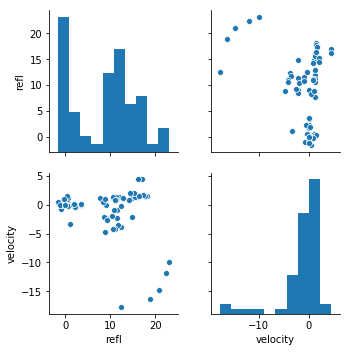

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
#sns.pairplot(refl_df[['refl', 'difphase', 'xcorr_ratio', 'velocity']])
sns.pairplot(refl_df[['refl',  'velocity']])
plt.show()

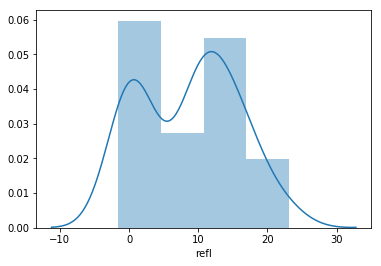

In [56]:
sns.distplot(refl_df['refl'])
plt.show()

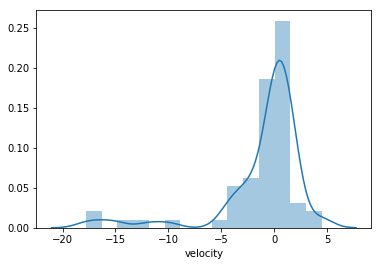

In [57]:
sns.distplot(refl_df['velocity'])
plt.show()

### https://stackoverflow.com/questions/10624937/convert-datetime-object-to-a-string-of-date-only-in-python


***For reference, here are the codes used in the mini-language:***



```
    %a Weekday as locale’s abbreviated name.
    %A Weekday as locale’s full name.
    %w Weekday as a decimal number, where 0 is Sunday and 6 is Saturday.
    %d Day of the month as a zero-padded decimal number.
    %b Month as locale’s abbreviated name.
    %B Month as locale’s full name.
    %m Month as a zero-padded decimal number. 01, ..., 12
    %y Year without century as a zero-padded decimal number. 00, ..., 99
    %Y Year with century as a decimal number. 1970, 1988, 2001, 2013
    %H Hour (24-hour clock) as a zero-padded decimal number. 00, ..., 23
    %I Hour (12-hour clock) as a zero-padded decimal number. 01, ..., 12
    %p Locale’s equivalent of either AM or PM.
    %M Minute as a zero-padded decimal number. 00, ..., 59
    %S Second as a zero-padded decimal number. 00, ..., 59
    %f Microsecond as a decimal number, zero-padded on the left. 000000, ..., 999999
    %z UTC offset in the form +HHMM or -HHMM (empty if naive), +0000, -0400, +1030
    %Z Time zone name (empty if naive), UTC, EST, CST
    %j Day of the year as a zero-padded decimal number. 001, ..., 366
    %U Week number of the year (Sunday is the first) as a zero padded decimal number.
    %W Week number of the year (Monday is first) as a decimal number.
    %c Locale’s appropriate date and time representation.
    %x Locale’s appropriate date representation.
    %X Locale’s appropriate time representation.
    %% A literal '%' character.
```


### https://stackoverflow.com/questions/39358092/range-as-dictionary-key-in-python
```
import random
class RangeDict(dict):
    def __getitem__(self, item):
        if type(item) != range: # or xrange in Python 2
            for key in self:
                if item in key:
                    return self[key]
        else:
            return super().__getitem__(item)

hour_check = RangeDict({range(0,2): '00', 
                        range(2,4): '02', 
                        range(4,6): '04', 
                        range(6,8): '06', 
                        range(8,10): '08', 
                        range(10,12): '10', 
                        range(12,14): '12', 
                        range(14,16): '14', 
                        range(16,18): '16', 
                        range(18,20): '18', 
                        range(20,22): '20', 
                        range(22,24): '22'})

hour_roll = random.randint(1, 20)
print(hour_roll, hour_check[hour_roll]) # prints result
```

In [142]:
rdr = 'KENX'
nexrad_dataset = os.path.join(os.getcwd(), 'nexrad_dataset','KENX')
total_downloaded_cfradials = list(filter(lambda s: rdr == s[:4], os.listdir(nexrad_dataset)))

print('cfradial files are retrieved : ', len(total_downloaded_cfradials))
print('cfradial files are required for dataset : ', len(total_cfradials))
common_cfradials = set(list(total_cfradials)) & set(total_downloaded_cfradials)
print('required cfradial files are retrieved so far : ', len(common_cfradials))
print('Missing cfradial files are : ', set(total_cfradials).difference(common_cfradials))
#list(common_cfradials)

cfradial files are retrieved :  1513
cfradial files are required for dataset :  467
required cfradial files are retrieved so far :  465
Missing cfradial files are :  {'KENXd20120426t0600.cfradial', 'KENXd20111103t1000.cfradial'}


In [143]:
#station_3 = 'KENX' # ex. KENXd20161226t1200.cfradial
#df_weather_outage_2011_2012['NEXRAD radar '+ station_3] = df_weather_outage_2011_2012['Fuse Card Start Time'].apply(lambda x : collect_nexradar(station_3, x) )
#total_cfradials = df_weather_outage_2011_2012['NEXRAD radar KENX'].unique()
#print('The number of unique cfradial files : ' , len(total_cfradials))

print('Number of radar files : ' , len(df_weather_outage_2011_2012['NEXRAD radar KENX'].unique()))
df_weather_outage_2011_2012[['LATITUDE','LONGITUDE', 'Start Date', 'End Date', 'NEXRAD radar KENX']].head(n=15)

Number of radar files :  467


,LATITUDE,LONGITUDE,Start Date,End Date,NEXRAD radar KENX
7,41.876413,-74.117170,20110118,20110119,KENXd20110118t1400.cfradial
24,41.945823,-74.023159,20110119,20110120,KENXd20110119t0800.cfradial
28,41.831942,-74.061525,20110119,20110120,KENXd20110119t1200.cfradial
41,41.881397,-74.021245,20110218,20110219,KENXd20110218t2200.cfradial
57,41.767883,-73.878455,20110219,20110220,KENXd20110219t0000.cfradial
71,42.058927,-73.908656,20110219,20110220,KENXd20110219t0400.cfradial
74,41.911963,-73.869072,20110219,20110220,KENXd20110219t0400.cfradial
91,41.933084,-74.171692,20110219,20110220,KENXd20110219t0800.cfradial
96,42.114457,-73.999625,20110219,20110220,KENXd20110219t0800.cfradial
104,41.726004,-74.411042,20110219,20110220,KENXd20110219t1000.cfradial


In [158]:
#find the missing cfradials
missing_cfradials = list(set(total_cfradials).difference(common_cfradials))
print(missing_cfradials)

#remove the rows containing the missing cfradials 
df_wo = df_weather_outage_2011_2012[~df_weather_outage_2011_2012['NEXRAD radar KENX'].isin(missing_cfradials)]
df_wo = df_wo.reset_index()
print(len(df_wo))
df_wo[['LATITUDE','LONGITUDE', 'NEXRAD radar KENX']].head(n=15)

['KENXd20120426t0600.cfradial', 'KENXd20111103t1000.cfradial']
3480


,LATITUDE,LONGITUDE,NEXRAD radar KENX
0,41.876413,-74.117170,KENXd20110118t1400.cfradial
1,41.945823,-74.023159,KENXd20110119t0800.cfradial
2,41.831942,-74.061525,KENXd20110119t1200.cfradial
3,41.881397,-74.021245,KENXd20110218t2200.cfradial
4,41.767883,-73.878455,KENXd20110219t0000.cfradial
5,42.058927,-73.908656,KENXd20110219t0400.cfradial
6,41.911963,-73.869072,KENXd20110219t0400.cfradial
7,41.933084,-74.171692,KENXd20110219t0800.cfradial
8,42.114457,-73.999625,KENXd20110219t0800.cfradial
9,41.726004,-74.411042,KENXd20110219t1000.cfradial


In [159]:
def missing_cfdial_fields(df, cfradial):
    m_idx = []
    for i, f in enumerate(df[cfradial]):
        full_file_name = os.path.join(os.getcwd(), 'nexrad_dataset', 'KENX', f)
        radar = pyart.io.read_cfradial(full_file_name, delay_field_loading=True)
        if len(list(radar.fields.keys())) < 3:
            m_idx.append(i)
            
    return m_idx

m_idx = missing_cfdial_fields(df_wo, 'NEXRAD radar KENX')

In [160]:
print(df_wo['NEXRAD radar KENX'].iloc[m_idx])
for f in df_wo['NEXRAD radar KENX'].iloc[m_idx]:
    full_file_name = os.path.join(os.getcwd(), 'nexrad_dataset', 'KENX', f)
    radar = pyart.io.read_cfradial(full_file_name, delay_field_loading=True)
    print(list(radar.fields.keys()))

1726    KENXd20111101t1800.cfradial
1727    KENXd20111101t1800.cfradial
1728    KENXd20111101t1800.cfradial
1729    KENXd20111101t1800.cfradial
1730    KENXd20111101t1800.cfradial
1731    KENXd20111101t1800.cfradial
1732    KENXd20111101t1800.cfradial
1733    KENXd20111101t2000.cfradial
Name: NEXRAD radar KENX, dtype: object
['reflectivity']
['reflectivity']
['reflectivity']
['reflectivity']
['reflectivity']
['reflectivity']
['reflectivity']
['reflectivity']


In [184]:
i = 0
for f, t, lat, lon in list(zip(df_wo['NEXRAD radar KENX'], df_wo['Fuse Card Start Time'],df_wo['LATITUDE'],df_wo['LONGITUDE'])):
    full_file_name = os.path.join(os.getcwd(), 'nexrad_dataset', 'KENX', f)
    radar = pyart.io.read_cfradial(full_file_name, delay_field_loading=True)
    #print(t, lat, lon, list(radar.fields.keys()), '\n')
    
    if 'velocity' not in list(radar.fields.keys()):
        print(f, list(radar.fields.keys()))
        
    if len(list(radar.fields.keys())) <3:
        i =i +1
print('number of missing files : ',i)

number of missing files :  0


In [163]:
df_wo = df_wo.drop(m_idx)
print(len(df_wo))

3472


In [164]:
from joblib import Parallel, delayed
import multiprocessing

def extract_data(lat, lon , filename, alt = 2000):
    full_file_name = os.path.join(os.getcwd(), 'nexrad_dataset', 'KENX', filename)
    radar = pyart.io.read_cfradial(full_file_name, delay_field_loading=True)
    #alt = 2000 # altitude (in meters.) 6500 to 20000 ft to find reflectivity at or near

    refl_dict = get_reflectivity(radar, float(lon), float(lat), alt)
    
    return  refl_dict

dataset = list(zip(df_wo['LATITUDE'],df_wo['LONGITUDE'], df_wo['NEXRAD radar KENX']))
print(len(dataset))

3472


In [167]:
df_wo[df_wo['NEXRAD radar KENX']=='KENXd20111101t1800.cfradial']

,index,Assist Order,CAIDI Constant Time (min),CIRCUIT,Callout Time (min),Cause Key,Customer Duration,Customer Hours,Customers Interrupted,Dispatch Time (min),...,Sub Cause,Sub Cause Key,Timesheet Employee Count,Total Time (min),Travel Time (min),Work Time (min),Interruption Cause,Start Date,End Date,NEXRAD radar KENX


In [122]:
import time

start = time.time()

refl_dicts = []
for lat, lon, filename in dataset[:20]:
    refl_dicts.append(extract_data(lat, lon , filename))
    
end = time.time()
print(end - start)

115.7916989326477


In [123]:
start = time.time()

num_cores = multiprocessing.cpu_count()
refl_dicts = Parallel(n_jobs=num_cores)(delayed(extract_data)(lat, lon , filename) for lat, lon, filename in dataset[:20])

end = time.time()
print(end - start)

/Users/ducvu/anaconda3/envs/outage-pred/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/ducvu/anaconda3/envs/outage-pred/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


37.8706259727478


In [173]:
print(len(dataset))

start = time.time()

num_cores = multiprocessing.cpu_count()
refl_dicts = Parallel(n_jobs=num_cores)(delayed(extract_data)(lat, lon , filename) for lat, lon, filename in dataset)

end = time.time()
print(end - start)

3472


/Users/ducvu/anaconda3/envs/outage-pred/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/ducvu/anaconda3/envs/outage-pred/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/ducvu/anaconda3/envs/outage-pred/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/ducvu/anaconda3/envs/outage-pred/lib/python3.6/site-packages/joblib/externals/

/Users/ducvu/anaconda3/envs/outage-pred/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/ducvu/anaconda3/envs/outage-pred/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/ducvu/anaconda3/envs/outage-pred/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/ducvu/anaconda3/envs/outage-pred/lib/python3.6/site-packages/joblib/externals/

3943.294149875641


In [179]:
df_refl = pd.DataFrame(merge_dict(refl_dicts))
df_refl = df_refl.sort_values(by='time', ascending=True)
print(len(df_refl))

df_refl.to_pickle('reflectivity_velocity.pkl')  # where to save it, usually as a .pkl
#df_refl = pd.read_pickle('reflectivity_velocity.pkl')
df_refl.head(n=15)

3472


,time,lat,lon,alt_m,refl,velocity
0,2011-01-18 14:02:04,41.859160,-74.141444,2435.0,10.939068,-12.581346
1,2011-01-19 08:02:36,41.928513,-74.047238,2435.0,0.000000,0.000000
2,2011-01-19 11:59:32,41.814751,-74.085651,2435.0,12.096394,-1.115756
3,2011-02-18 22:00:54,41.864159,-74.045296,2435.0,-3.150364,0.000000
4,2011-02-19 00:00:33,41.750803,-73.902128,2435.0,22.155628,-0.001582
5,2011-02-19 03:59:09,42.041518,-73.932509,2435.0,0.000000,0.000000
6,2011-02-19 03:59:41,41.894723,-73.892777,2435.0,-4.259410,0.000000
7,2011-02-19 08:02:48,41.915757,-74.196115,2435.0,-3.086093,5.801986
8,2011-02-19 08:03:50,42.096969,-74.023713,2435.0,2.485110,7.621109
9,2011-02-19 10:03:43,41.708858,-74.435946,2435.0,1.577756,-0.600253


In [182]:
df_refl_velo = pd.read_pickle('reflectivity_velocity.pkl')
# hurricane sandy : October 22, 2012 – November 2, 2012
df_sandy = df_refl_velo[(df_refl_velo['time'] >= '2012-10-22') &(df_refl_velo['time'] <= '2012-11-02')]
df_sandy

,time,lat,lon,alt_m,refl,velocity
2378,2012-10-29 04:01:04,41.654019,-74.073817,2439.0,0.000000,0.000000
2377,2012-10-29 04:01:37,41.864322,-74.367713,2439.0,0.000000,0.000000
2380,2012-10-29 06:02:08,41.658529,-74.282414,2439.0,0.000000,0.000000
2379,2012-10-29 06:03:10,41.978328,-74.117736,2439.0,0.000000,0.000000
2381,2012-10-29 06:03:10,41.764055,-74.096814,2439.0,0.000000,0.000000
2385,2012-10-29 07:57:48,41.508780,-74.175846,2439.0,6.310781,3.000000
2384,2012-10-29 07:57:48,41.650091,-74.052596,2439.0,0.000000,0.000000
2383,2012-10-29 07:59:21,41.992174,-74.010509,2439.0,0.000000,0.000000
2382,2012-10-29 07:59:22,41.952132,-74.121370,2439.0,0.000000,0.000000
2389,2012-10-29 09:59:22,41.571618,-74.152616,2439.0,3.626705,-9.455709


In [183]:
#Hurricane Irene : August 21, 2011 – August 28, 2011
df_irene = df_refl_velo[(df_refl_velo['time'] >= '2011-08-21') &(df_refl_velo['time'] <= '2011-08-28')]
df_irene

,time,lat,lon,alt_m,refl,velocity
344,2011-08-27 17:59:53,42.216565,-73.883878,2435.0,-4.252008,-2.522239
346,2011-08-27 19:59:33,41.521148,-74.044454,2435.0,17.727938,-3.742216
345,2011-08-27 19:59:34,41.682396,-74.216976,2435.0,17.884516,-3.863490
347,2011-08-27 22:01:36,41.960817,-73.723297,2435.0,-0.237914,-6.815419


# Process data parallel with Multiprocessing (not efficient with large dataset yet !!!)

In [78]:
from joblib import Parallel, delayed
import multiprocessing

work_dir = os.getcwd()
rdr = 'KENX'
files = tuple(filter(lambda s: rdr == s[:4], os.listdir()))
locations = list(zip(df_weather_outage['LATITUDE'], df_weather_outage['LONGITUDE']))
refl_dicts = []

def extract_data(lat, lon , files):
    for i, filename in enumerate(files):
        full_file_name = os.path.join(work_dir, filename)
        radar = pyart.io.read_cfradial(full_file_name, delay_field_loading=True)
        alt = 2000 # altitude (in meters.) 6500 to 20000 ft to find reflectivity at or near

        new_ref = get_reflectivity(radar, float(lon), float(lat), alt)
        refl_dicts.append(new_ref)
        
    return  refl_dicts  

num_cores = multiprocessing.cpu_count()
results = Parallel(n_jobs=num_cores)(delayed(extract_data)(lat, lon , files) for lat, lon in locations[:2])

In [80]:
import functools

#flat_results = [item for sublist in results for item in sublist]
flat_results = functools.reduce(operator.iconcat, results, [])

print(len(results))
print(len(flat_results))

results_data = merge_dict(flat_results)  

results_df = pd.DataFrame(results_data)
results_df = results_df.sort_values(by='time', ascending=True)
print(len(results_df))
results_df

2
26
26


,time,lat,lon,alt_m,refl,difphase,xcorr_ratio,velocity
23,2016-12-26 00:02:58,41.928513,-74.047238,1439.0,-3.094243,150.771576,0.738585,5.000000
10,2016-12-26 00:02:59,41.859161,-74.141444,1439.0,0.000000,0.000000,0.000000,0.000000
21,2016-12-26 01:59:01,41.928513,-74.047238,1439.0,-3.219591,81.529976,0.472935,10.361791
8,2016-12-26 01:59:02,41.859161,-74.141444,1439.0,0.000000,0.000000,0.000000,0.000000
17,2016-12-26 03:58:51,41.928513,-74.047238,1439.0,0.000000,0.000000,0.000000,0.000000
4,2016-12-26 03:58:52,41.859161,-74.141444,1439.0,0.000000,0.000000,0.000000,0.000000
13,2016-12-26 06:03:09,41.928513,-74.047238,1439.0,0.000000,0.000000,0.000000,0.000000
0,2016-12-26 06:03:10,41.859161,-74.141444,1439.0,0.000000,0.000000,0.000000,0.000000
11,2016-12-26 07:59:19,41.859161,-74.141444,1439.0,0.000000,0.000000,0.000000,0.000000
24,2016-12-26 08:00:31,41.928513,-74.047238,1439.0,0.000000,0.000000,0.000000,0.000000


In [ ]:
lats , lons = df_weather_outage['LATITUDE'].tolist(), df_weather_outage['LONGITUDE'].tolist()
a = list(zip(lats , lons))
for lat, lin in a[:10]:
    print(lat, lon)

In [ ]:
# build filename list
rdr = 'KENX'
files = tuple(filter(lambda s: rdr == s[:4], os.listdir()))
lats , lons = df_weather_outage['LATITUDE'].tolist(), df_weather_outage['LONGITUDE'].tolist()


work_dir = os.getcwd()
refl_dicts = []
c = 0
for lat, lon in list(zip(lats , lons)):
    c = c + 1
    print('\n\n-------------------------')
    print("Reading", c,  ' in ',  len(lats))

    for i,filename in enumerate(files):
        #print('\n\n-------------------------')
        #print("Reading", filename, i+1, 'of', len(files), 'files')
        #print(datetime.now())
        full_file_name = os.path.join(work_dir, filename)
        radar = pyart.io.read_cfradial(full_file_name, delay_field_loading=True)
        #altitudes = range(2000,6001,1000) # altitude (in meters.) 6500 to 20000 ft to find reflectivity at or near
        altitudes = [1000] # altitude (in meters.) 6500 to 20000 ft to find reflectivity at or near
        #lat= 43.217806   # latitude (in degrees) to find reflectivity at or near
        #lon = -74.872220 # longitude (in degrees) to find reflectivity at or near


        for alt in altitudes:
            #print('altitude:', alt, 'm')
            new_ref = get_reflectivity(radar, float(lon), float(lat), alt)
            refl_dicts.append(new_ref)
    
refl_data = merge_dict(refl_dicts)  

refl_df = pd.DataFrame(refl_data)
refl_df = refl_df.sort_values(by='time', ascending=True)
print(len(refl_df))

In [ ]:
import multiprocessing

num_cores = multiprocessing.cpu_count()
num_cores

In [ ]:
from joblib import Parallel, delayed
import multiprocessing

inputs = range(100) 
def processInput(i):
    return i * i

num_cores = multiprocessing.cpu_count()

results = Parallel(n_jobs=num_cores)(delayed(processInput)(i) for i in inputs)
print(results)

In [ ]:
# build filename list
rdr = 'KENX'
files = tuple(filter(lambda s: rdr == s[:4], os.listdir()))
lats , lons = df_weather_outage['LATITUDE'].tolist(), df_weather_outage['LONGITUDE'].tolist()


work_dir = os.getcwd()
refl_dicts = []
c = 0
for lat, lon in list(zip(lats , lons)):
    c = c + 1
    print('\n\n-------------------------')
    print("Reading", c,  ' in ',  len(lats))

    for i,filename in enumerate(files):
        #print('\n\n-------------------------')
        #print("Reading", filename, i+1, 'of', len(files), 'files')
        #print(datetime.now())
        full_file_name = os.path.join(work_dir, filename)
        radar = pyart.io.read_cfradial(full_file_name, delay_field_loading=True)
        #altitudes = range(2000,6001,1000) # altitude (in meters.) 6500 to 20000 ft to find reflectivity at or near
        altitudes = [1000] # altitude (in meters.) 6500 to 20000 ft to find reflectivity at or near
        #lat= 43.217806   # latitude (in degrees) to find reflectivity at or near
        #lon = -74.872220 # longitude (in degrees) to find reflectivity at or near


        for alt in altitudes:
            #print('altitude:', alt, 'm')
            new_ref = get_reflectivity(radar, float(lon), float(lat), alt)
            refl_dicts.append(new_ref)
    
refl_data = merge_dict(refl_dicts)  

refl_df = pd.DataFrame(refl_data)
refl_df = refl_df.sort_values(by='time', ascending=True)
print(len(refl_df))

In [ ]:
from joblib import Parallel, delayed
import multiprocessing

work_dir = os.getcwd()
rdr = 'KENX'
files = tuple(filter(lambda s: rdr == s[:4], os.listdir()))
locations = list(zip(df_weather_outage['LATITUDE'], df_weather_outage['LONGITUDE']))
refl_dicts = []

def extract_data(lat, lon , files):
    for i, filename in enumerate(files):
        full_file_name = os.path.join(work_dir, filename)
        radar = pyart.io.read_cfradial(full_file_name, delay_field_loading=True)
        alt = 1000 # altitude (in meters.) 6500 to 20000 ft to find reflectivity at or near

        new_ref = get_reflectivity(radar, float(lon), float(lat), alt)
        refl_dicts.append(new_ref)
        
    return  refl_dicts  

num_cores = multiprocessing.cpu_count()
results = Parallel(n_jobs=num_cores)(delayed(extract_data)(lat, lon , files) for lat, lon in locations)

print(results)

In [ ]:
import functools

#flat_results = [item for sublist in results for item in sublist]
flat_results = functools.reduce(operator.iconcat, results, [])

print(len(results))
print(len(flat_results))

results_data = merge_dict(flat_results)  

results_df = pd.DataFrame(results_data)
results_df = results_df.sort_values(by='time', ascending=True)
print(len(results_df))

In [ ]:
results_df

In [ ]:
from collections import Iterable


def flatten(items):
    """Yield items from any nested iterable; see Reference."""
    for x in items:
        if isinstance(x, Iterable) and not isinstance(x, (str, bytes)):
            for sub_x in flatten(x):
                yield sub_x
        else:
            yield x


%timeit list(flatten(results)) 
%timeit  [item for sublist in results for item in sublist]    

100%|██████████| 16/16 [02:43<00:00, 28.92s/it]A


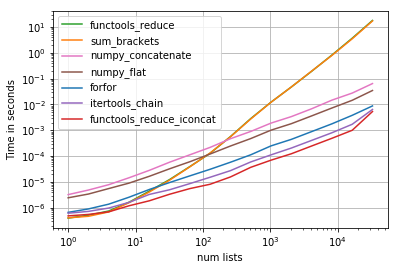

In [39]:
import functools
import itertools
import numpy
import operator
import perfplot


def forfor(a):
    return [item for sublist in a for item in sublist]



def sum_brackets(a):
    return sum(a, [])


def functools_reduce(a):
    return functools.reduce(operator.concat, a)


def functools_reduce_iconcat(a):
    return functools.reduce(operator.iconcat, a, [])


def itertools_chain(a):
    return list(itertools.chain.from_iterable(a))


def numpy_flat(a):
    return list(numpy.array(a).flat)


def numpy_concatenate(a):
    return list(numpy.concatenate(a))


perfplot.show(
    setup=lambda n: [list(range(10))] * n,
    kernels=[
        forfor, sum_brackets, functools_reduce, functools_reduce_iconcat,
        itertools_chain, numpy_flat, numpy_concatenate
        ],
    n_range=[2**k for k in range(16)],
    logx=True,
    logy=True,
    xlabel='num lists'
    )

In [ ]:
%timeit  functools.reduce(operator.iconcat, results, [])
%timeit  list(itertools.chain.from_iterable(results))
%timeit  [item for sublist in results for item in sublist]    

In [ ]:
a = functools.reduce(operator.iconcat, results, [])
len(a)

## parallelize a simple Python loop

https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-list-of-lists

https://stackoverflow.com/questions/9786102/how-do-i-parallelize-a-simple-python-loop

## Koalas: pandas API on Apache Spark


https://github.com/databricks/koalas

In [172]:
import databricks.koalas as ks

AttributeError: module 'pyarrow' has no attribute 'compat'

# Reference:


- ***Notebook NEXRAD radar data*** : 
    - https://github.com/openradar/AMS_radar_in_the_cloud/blob/master/notebooks/Basic%20PyART.ipynb


- ***Mapping NOAA NEXRAD radar data with CartoDB*** : 
    - https://carto.com/blog/mapping-nexrad-radar-data/


- ***Py-ART Users*** : 
    - https://groups.google.com/forum/#!searchin/pyart-users/find_x_y_displacement/pyart-users/NYRAKvv1R9A/RVup7ohZAwAJ


- ***Find the reflectivity of the nearest radar gate and the interpolated reflectivity to a given location*** :
    - https://github.com/ARM-DOE/pyart/issues/448


- ***Python Visualization on Shining a Light on Household Solar Energy*** : 
    - https://jtanwk.github.io/us-solar-d3/


- ***Shining a Light on Household Solar Energy*** : 
    - https://jtanwk.github.io/us-solar/


- ***Run Python Scripts on Google Colaboratory*** : 
    - https://edenau.github.io/google-colab/
    
    
    
    